## multi-e5-base Classifier evaluation

> Evaluate multi-e5-base embeddings w/ linear classifier head, that was trained on predicted labels (Setfit+fine-tuned mistral); on held-eval dataset

**Steps / end goal**
- 1. Started with our +-500 human annotated comments (out of 200k)
- 2. Synthetic data generation (comments + label) w/ Mistral OpenHermes : around 2k samples
- 3. Prepare instruction dataset, before fine tuning, using Alpaca format  
- 4. Fine-tune mistral-7B (classif. / label completion), using unsloth, on train + synthetic data.  
- 5. More tests on the fine-tuned model. If good enough, labels unlabeled data to several k examples (fine-tuned model as a classifier or weighted avg. w/ our Few shot SetFit baseline).
- 6. Extend dataset to several 20k examples with fine-tuned Mistral (and/or ensemble model w/ Setfit) doing the classification.  
- 7. End goal being deployment/inference performance: train a classifier on the extended dataset using bge-m3 or multi-e5 embeddings.  
- 8. Benchmark classifier **<- we're here**

**Ressources**  
- [MLabonne Repo](https://github.com/mlabonne/llm-course)  
- [Dataset Gen - Kaggle example](https://www.kaggle.com/code/phanisrikanth/generate-synthetic-essays-with-mistral-7b-instruct)  
- [Dataset Gen - blog w/ prompt examples](https://hendrik.works/blog/leveraging-underrepresented-data)  
- [Prepare dataset- /r/LocalLLaMA best practice classi](https://www.reddit.com/r/LocalLLaMA/comments/173o5dv/comment/k448ye1/?utm_source=reddit&utm_medium=web2x&context=3)  
- [Prepare dataset - using gpt3.5](https://medium.com/@kshitiz.sahay26/how-i-created-an-instruction-dataset-using-gpt-3-5-to-fine-tune-llama-2-for-news-classification-ed02fe41c81f) 
- [Prepare dataset - Predibase prompts for diverse fine-tuning tasks](https://predibase.com/lora-land)
- [Fine tune OpenHermes-2.5-Mistral-7B - including prompt template gen](https://towardsdatascience.com/fine-tune-a-mistral-7b-model-with-direct-preference-optimization-708042745aac)  
- [Fine tune - Unsloth colab example](https://colab.research.google.com/drive/1Dyauq4kTZoLewQ1cApceUQVNcnnNTzg_?usp=sharing)
- [Fine tune - w/o unsloth](https://gathnex.medium.com/mistral-7b-fine-tuning-a-step-by-step-guide-52122cdbeca8) or [wandb](https://wandb.ai/vincenttu/finetuning_mistral7b/reports/Fine-tuning-Mistral-7B-with-W-B--Vmlldzo1NTc3MjMy) or [philschmid](https://www.philschmid.de/fine-tune-llms-in-2024-with-trl#6-deploy-the-llm-for-production)
- [Fine tune - impact of parameters S. Raschka](https://lightning.ai/pages/community/lora-insights/)
- [Embeddings - multilingual, latest comparison](https://towardsdatascience.com/openai-vs-open-source-multilingual-embedding-models-e5ccb7c90f05)
- [philschmid ONNX optim](https://github.com/philschmid/optimum-transformers-optimizations/blob/master/notebook.ipynb)

In [1]:
%%capture
!pip install transformers datasets evaluate

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from time import perf_counter
from tqdm.auto import tqdm

from datasets import load_dataset, Dataset, DatasetDict
import evaluate
from evaluate import load
from evaluate.visualization import radar_plot

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers.pipelines.pt_utils import KeyDataset

2024-03-26 16:26:19.916576: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 16:26:19.916789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 16:26:20.120669: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### Load datasets : original data (train/test, manually labeled)

In [3]:
%%capture
# load original, custom and human-annotated dataset, previously saved on HF
filepath = "gentilrenard/lmd_ukraine_comments"

# HF Datasets format
ds = load_dataset(filepath)

In [4]:
# Extract train and eval datasets from DatasetDict
train_dataset = ds['train']
eval_dataset = ds['validation']

# Define our eval column with ground truth labels
eval_labels = eval_dataset["label"]

# dataset structure
print(ds)

DatasetDict({
    unlabeled: Dataset({
        features: ['text', 'label'],
        num_rows: 174891
    })
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 323
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 139
    })
})


#### Evaluation metrics / func

In [5]:
def perf_global(predictions: list[int], references: list[int]) -> dict[str, float]:
    """
    Computes model global perf. metrics
    
    Args:
    predictions (list[int]): The predicted labels by the model.
    references (list[int]): The true labels.
    """
    # Load metrics from evaluate
    accuracy_metric = load("accuracy")
    f1_metric = load("f1", config_name="multiclass")
    precision_metric = load("precision", config_name="multiclass")
    recall_metric = load("recall", config_name="multiclass")
    
    accuracy_result = accuracy_metric.compute(predictions=predictions, references=references)
    f1_result = f1_metric.compute(predictions=predictions, references=references, average="macro")
    precision_result = precision_metric.compute(predictions=predictions, references=references, average="macro")
    recall_result = recall_metric.compute(predictions=predictions, references=references, average="macro")
    
    return {
        "accuracy": accuracy_result["accuracy"],
        "f1": f1_result["f1"],
        "precision": precision_result["precision"],
        "recall": recall_result["recall"]
    }


def perf_per_class(predictions: list[int], references: list[int]) -> dict[str, float]:
    """
    Compute metrics per class.
    """
    f1_detail = load("f1", config_name="multiclass", average=None)
    precision_detail = load("precision", config_name="multiclass", average=None)
    recall_detail = load("recall", config_name="multiclass", average=None)
    
    f1_result = f1_detail.compute(predictions=predictions, references=references, average=None)
    precision_result = precision_detail.compute(predictions=predictions, references=references, average=None)
    recall_result = recall_detail.compute(predictions=predictions, references=references, average=None)
    
    return {
        "f1_per_class": f1_result["f1"],
        "precision_per_class": precision_result["precision"],
        "recall_per_class": recall_result["recall"],
    }

# TODO
def time_model(pipe):
    """
    Compute inference speed. (Huggingface pipeline only)
    """
    payload = """Vous êtes naif si vous croyez que seuls les Russes ont ce genre de comportement en tant de guerre...vous devez être de ceux qui croient en la guerre "propre" que les Occidentaux prétendre faire depuis 40 ans parfois avec les Russes comme alliés d'ailleurs."""
    latencies = []
    # warm up
    for _ in range(10):
        _ = pipe(payload)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ =  pipe(payload)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    return {
        "time_avg_ms": time_avg_ms,
        "time_std_ms": time_std_ms
    }

## Classifier evaluation

- training : 300 labeled + 20k model annotated + standard loss func : 70,5% acc, 65% f1, f1_class1:43%, prec_class1:68%, recall_f1:31%
- training: **300 labeled + 20k model annotated + weighted loss func: 76,9% acc, 74,9% f1, f1_class1:64%, prec_class1:70%, recall_f1:60%**
- training: 300 labeled + 5k model annotated + 2k synthetic + weighted loss func: 76,2% acc, 73,8% f1, f1_class1:61,2%, recall_f1:54%
- training: 300 labeled + *2k* model annotated + 2k synthetic + weighted loss func: 73,3% acc, 69,7% f1, f1_class1: 53,5%%, recall_f1:42%
- training : 300 labeled + only the 2k synthetic + weighted loss func : 69% acc, 67% f1, f1_class1:55%, recall_f1: 48%

#### Load model, tokenizer

In [6]:
%%capture
# TODO, save tokenizer in the same repository as the model
checkpoint = "gentilrenard/multi-e5-base_lmd-comments_v1"
tokenizer_model = "intfloat/multilingual-e5-base"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_model)

#### Inference on eval_dataset

Compute our custom metrics on held eval dataset

In [7]:
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)
print(eval_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 139
})


In [8]:
preds = [] 
for out in tqdm(pipe(KeyDataset(eval_dataset, "text"))):
    print(out)
    parsed_label = out['label'].split('LABEL_')[1]
    preds.append(parsed_label)

  0%|          | 0/139 [00:00<?, ?it/s]

{'label': 'LABEL_2', 'score': 0.9995102882385254}
{'label': 'LABEL_1', 'score': 0.9968632459640503}
{'label': 'LABEL_0', 'score': 0.9349251985549927}
{'label': 'LABEL_1', 'score': 0.9911331534385681}
{'label': 'LABEL_2', 'score': 0.6225778460502625}
{'label': 'LABEL_0', 'score': 0.8489839434623718}
{'label': 'LABEL_2', 'score': 0.9951719641685486}
{'label': 'LABEL_1', 'score': 0.8480927348136902}
{'label': 'LABEL_2', 'score': 0.9992936849594116}
{'label': 'LABEL_1', 'score': 0.9281809329986572}
{'label': 'LABEL_0', 'score': 0.982722282409668}
{'label': 'LABEL_2', 'score': 0.9994214773178101}
{'label': 'LABEL_1', 'score': 0.9894081354141235}
{'label': 'LABEL_0', 'score': 0.9919054508209229}
{'label': 'LABEL_2', 'score': 0.8930466771125793}
{'label': 'LABEL_0', 'score': 0.994690477848053}
{'label': 'LABEL_0', 'score': 0.9688159227371216}
{'label': 'LABEL_1', 'score': 0.9966701865196228}
{'label': 'LABEL_0', 'score': 0.974757730960846}
{'label': 'LABEL_0', 'score': 0.9498710036277771}
{'l

#### Evaluate

In [9]:
e5_global_metrics = perf_global(predictions=preds, references=eval_labels)
print(f"Model overall performance:\n{e5_global_metrics}")

e5_detailed_metrics = perf_per_class(predictions=preds, references=eval_labels)
print(f"Per class:\n{e5_detailed_metrics}")

Model overall performance:
{'accuracy': 0.7697841726618705, 'f1': 0.7491320273928969, 'precision': 0.7550774134790528, 'recall': 0.7481481481481481}
Per class:
{'f1_per_class': array([0.71428571, 0.64615385, 0.88695652]), 'precision_per_class': array([0.72916667, 0.7       , 0.83606557]), 'recall_per_class': array([0.7       , 0.6       , 0.94444444])}


#### Latency evaluation (P100 cpu)

In [10]:
latency = time_model(pipe)
latency

{'time_avg_ms': 169.1882769100016, 'time_std_ms': 4.3959080507717285}

## Benchmark w/ previous models

Benchmark w/ previous performance scores recorded in setfit_mistral_evaluation [notebook](https://www.kaggle.com/code/amadevs/lmd-setfit-mistral-evaluation)  
**tl;dr:**  
Fine-tuned (w/ synthetic data) Mistral shows awesome performance, including on minority class 1 "pro russian". Setfit was amazing considering the few labels used, but was subpar on class 1.  
Our linear activation layer on top of multi-e5 embeddings, trained on synthetically-augmented data, shows very good results (while being way faster than Mistral), higher than SetFit and contrary to the latter is way better on classifying our minority class of interest (pro russian comments).  
Latency wise, ft-mistral (P100 gpu, unsloth inference engine) : 900ms (batch size=1), multi-e5-base : 100ms (P100, batch size=1), multi-e5-small: 54ms and Setfit: 5ms (batched).

**Models comparison : overall performance**

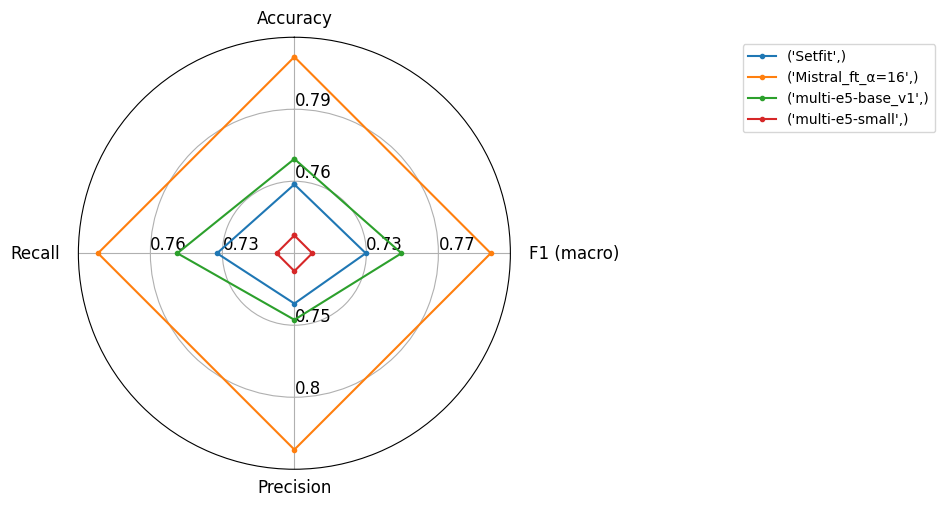

In [11]:
model_perf = [
    {"Accuracy":0.76, "F1 (macro)":0.73, "Precision": 0.74, "Recall":0.73},#, "latency (ms)":5},
    {"Accuracy":0.81, "F1 (macro)":0.80, "Precision":0.83, "Recall":0.79},#, "latency (ms)":940},
    {"Accuracy":0.77, "F1 (macro)":0.75, "Precision":0.75, "Recall":0.75},#, "latency (ms)":100},
    {"Accuracy":0.74, "F1 (macro)":0.70, "Precision":0.72, "Recall":0.70},#, "latency (ms)":54},
   ]
model_names = ["Setfit", "Mistral_ft_α=16", "multi-e5-base_v1", "multi-e5-small"]
plot = radar_plot(data=model_perf, model_names=model_names)#, invert_range=["latency (ms)"])
plot.show()

**Per class : class 1 (pro_russian)**

Reminder classes :  
0: pro Ukraine, 1: pro Russia, 2: no opinion/off topic

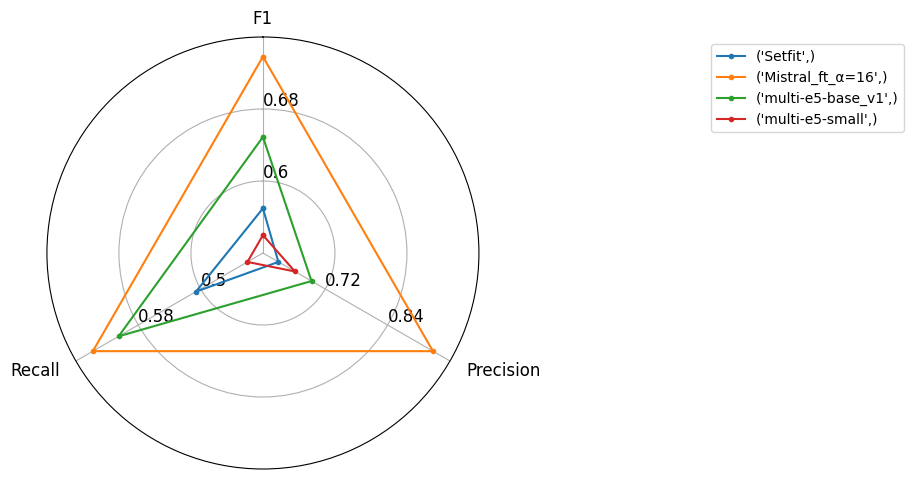

In [12]:
cls_1_perf = [
    {"F1":0.57, "Precision":0.64, "Recall":0.51},
    {"F1":0.74, "Precision":0.92, "Recall":0.63},
    {"F1":0.65, "Precision":0.7, "Recall":0.6},
    {"F1":0.54, "Precision":0.67, "Recall":0.45},
   ]
model_names = ["Setfit", "Mistral_ft_α=16", "multi-e5-base_v1", "multi-e5-small"]
plot = radar_plot(data=cls_1_perf, model_names=model_names)
plot.show()